# IMPORT LIBRARY


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# LOAD DATA & DATA CLEANING

Dataset shape after preprocessing: (9535, 8)


<Figure size 1200x600 with 0 Axes>

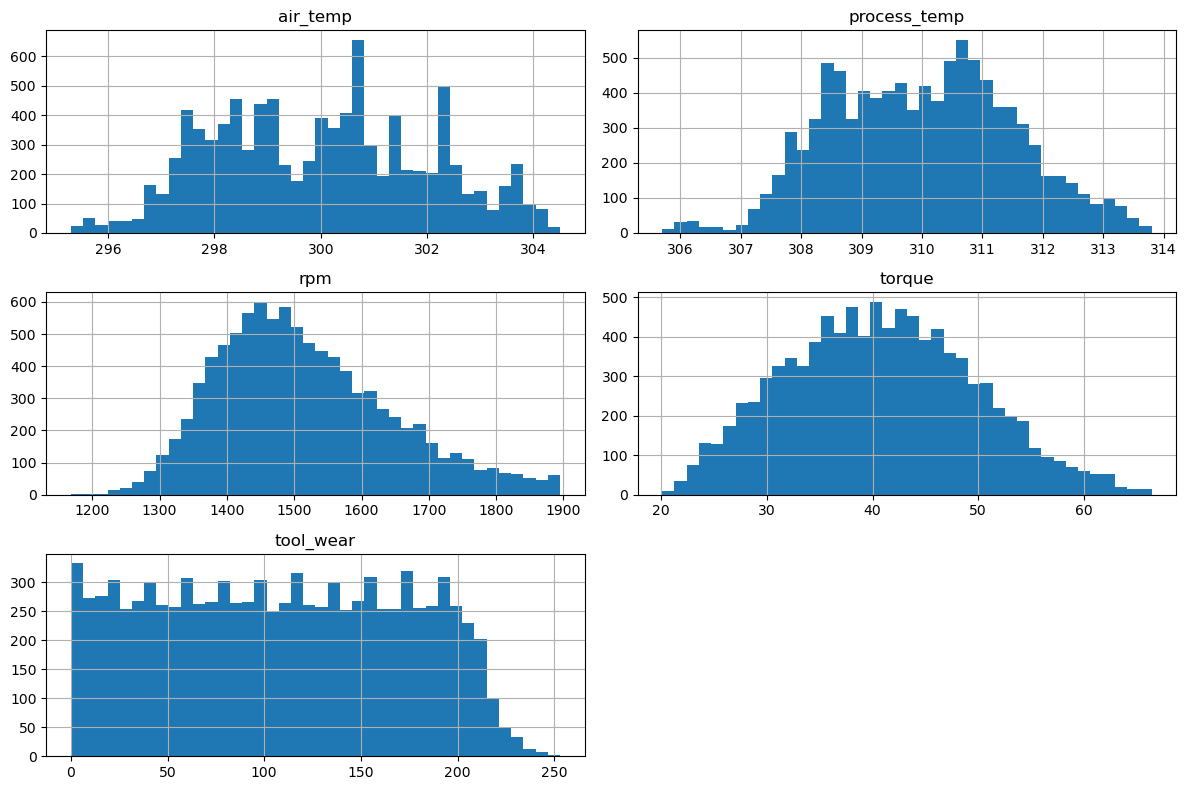

In [2]:
df = pd.read_csv("predictive_maintenance.csv")

drop_cols = ["UDI", "Product ID"]
df = df.drop(columns=drop_cols, errors="ignore")

df = df.rename(
    columns={
        "Air temperature [K]": "air_temp",
        "Process temperature [K]": "process_temp",
        "Rotational speed [rpm]": "rpm",
        "Torque [Nm]": "torque",
        "Tool wear [min]": "tool_wear",
        "Failure Type": "failure",
    }
)

df = df.drop_duplicates()

num_cols = ["air_temp", "process_temp", "rpm", "torque", "tool_wear"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df


df = remove_outliers_iqr(df, num_cols)

print(f"Dataset shape after preprocessing: {df.shape}")

plt.figure(figsize=(12,6))
df[num_cols].hist(bins=40, figsize=(12,8))
plt.tight_layout()
plt.show()

In [3]:
df['failure'].value_counts()

failure
No Failure                  9263
Heat Dissipation Failure     110
Overstrain Failure            76
Tool Wear Failure             41
Power Failure                 27
Random Failures               18
Name: count, dtype: int64

# FEATURE ENGINEERING


In [4]:
df["temp_diff"] = df["process_temp"] - df["air_temp"]
df["torque_rpm_ratio"] = df["torque"] / (df["rpm"] + 1e-5)
df["power"] = df["torque"] * df["rpm"] / 9.5488
df["temp_stress"] = df["process_temp"] / (df["air_temp"] + 1e-5)
df["wear_per_rpm"] = df["tool_wear"] / (df["rpm"] + 1e-5)
df["torque_squared"] = df["torque"] ** 2
df["tool_wear_squared"] = df["tool_wear"] ** 2
df["torque_wear_interaction"] = df["torque"] * df["tool_wear"]
df["rpm_temp_interaction"] = df["rpm"] * df["temp_diff"]
df["power_wear_ratio"] = df["power"] / (df["tool_wear"] + 1e-5)

print(f"Total features after engineering: {len(df.columns) - 2}")

Total features after engineering: 16


In [5]:
print(df.loc[df["failure"] == "Random Failures"])

     Type  air_temp  process_temp   rpm  torque  tool_wear  Target  \
1221    M     297.0         308.3  1399    46.4        132       0   
1302    L     298.6         309.8  1505    45.7        144       0   
1748    H     298.4         307.7  1626    31.1        166       0   
2072    L     299.6         309.5  1570    35.5        189       0   
2559    L     299.3         309.0  1447    50.4        140       0   
3065    M     300.1         309.2  1687    27.7         95       0   
3452    H     301.6         310.5  1602    32.3          2       0   
5471    L     302.7         312.3  1346    61.2        170       0   
5489    L     302.6         312.1  1499    35.0        215       0   
5495    H     302.9         312.5  1357    55.0         12       0   
5509    L     302.8         312.2  1509    36.5         52       0   
5553    L     302.5         311.9  1306    59.7        172       0   
5639    L     302.6         312.1  1668    28.7        180       0   
6091    L     300.9 

# PREPROCESSING

In [6]:
type_le = LabelEncoder()
failure_le = LabelEncoder()
df["Type"] = type_le.fit_transform(df["Type"])
df["failure"] = failure_le.fit_transform(df["failure"])

X = df.drop(columns=["Target", "failure"])
y = df["failure"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nOriginal training distribution:")
print(Counter(y_train))


Original training distribution:
Counter({1: 7410, 0: 88, 2: 61, 5: 33, 3: 22, 4: 14})


# RESAMPLING

In [7]:
over = SMOTE(
    sampling_strategy={
        0: 500,  # Heat Dissipation
        2: 500,  # Overstrain
        3: 200,  # Power
        4: 200,  # Random Failures
        5: 300,  # Tool Wear
    },
    k_neighbors=3,
    random_state=42,
)

under = RandomUnderSampler(
    sampling_strategy={1: 1000}, random_state=42  # No Failure
)

sampling_pipeline = ImbPipeline([("over", over), ("under", under)])
X_train_res, y_train_res = sampling_pipeline.fit_resample(X_train, y_train)

print(f"Resampled training distribution:")
print(Counter(y_train_res))

Resampled training distribution:
Counter({1: 1000, 0: 500, 2: 500, 5: 300, 3: 200, 4: 200})


# MODELING

In [8]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train_res)

class_weight_dict = {
    0: 2.0,  # Heat Dissipation - NAIKKAN
    1: 0.3,  # No Failure - TURUNKAN LEBIH BANYAK
    2: 2.0,  # Overstrain - NAIKKAN
    3: 3.5,  # Power - NAIKKAN
    4: 5.0,  # Random Failures - EXTREME BOOST
    5: 5.0,  # Tool Wear - EXTREME BOOST
}

for i, label in enumerate(y_train_res):
    sample_weights[i] *= class_weight_dict[label]

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y)),
    random_state=42,
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    max_delta_step=2
)

param_dist = {
    "n_estimators": [500, 700, 1000],
    "max_depth": [6, 8, 10, 12], 
    "learning_rate": [0.01, 0.03, 0.05], 
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "min_child_weight": [1, 2, 3], 
    "gamma": [0, 0.05, 0.1],
    "reg_alpha": [0, 0.1, 0.3],
    "reg_lambda": [1, 1.5, 2],
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  
    scoring="recall_macro", 
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

print("\nStarting Randomized Search...")
random_search.fit(
    X_train_res, y_train_res, sample_weight=sample_weights
)

best_model = random_search.best_estimator_

print("\n✅ Best parameters found:")
print(random_search.best_params_)


Starting Randomized Search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.03, max_depth=8, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.03, max_depth=8, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.03, max_depth=8, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=   1.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=0.9, gamma=0

# EVALUASI


=== Classification Report ===
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.85      1.00      0.92        22
              No Failure       1.00      0.92      0.96      1853
      Overstrain Failure       0.65      1.00      0.79        15
           Power Failure       0.83      1.00      0.91         5
         Random Failures       0.01      0.25      0.03         4
       Tool Wear Failure       0.08      0.75      0.14         8

                accuracy                           0.92      1907
               macro avg       0.57      0.82      0.62      1907
            weighted avg       0.99      0.92      0.95      1907



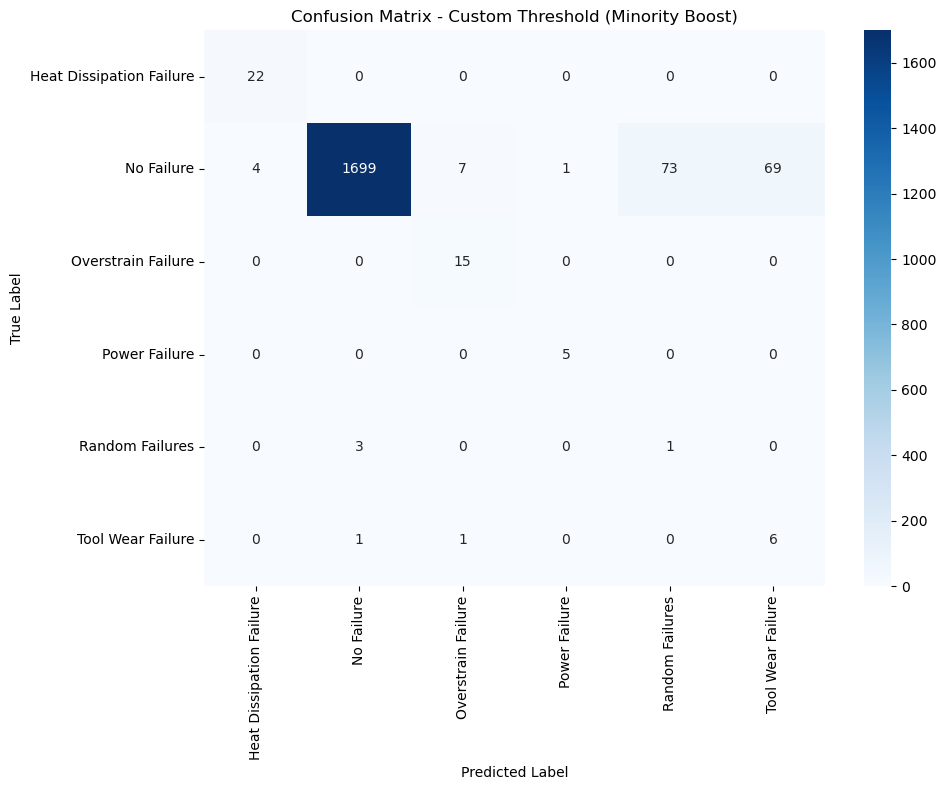

In [9]:
y_pred = best_model.predict(X_test)
print("\n=== Classification Report ===")
print(
    classification_report(
        y_test, y_pred, target_names=failure_le.classes_, zero_division=0
    )
)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=failure_le.classes_,
    yticklabels=failure_le.classes_,
)
plt.title("Confusion Matrix - Custom Threshold (Minority Boost)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

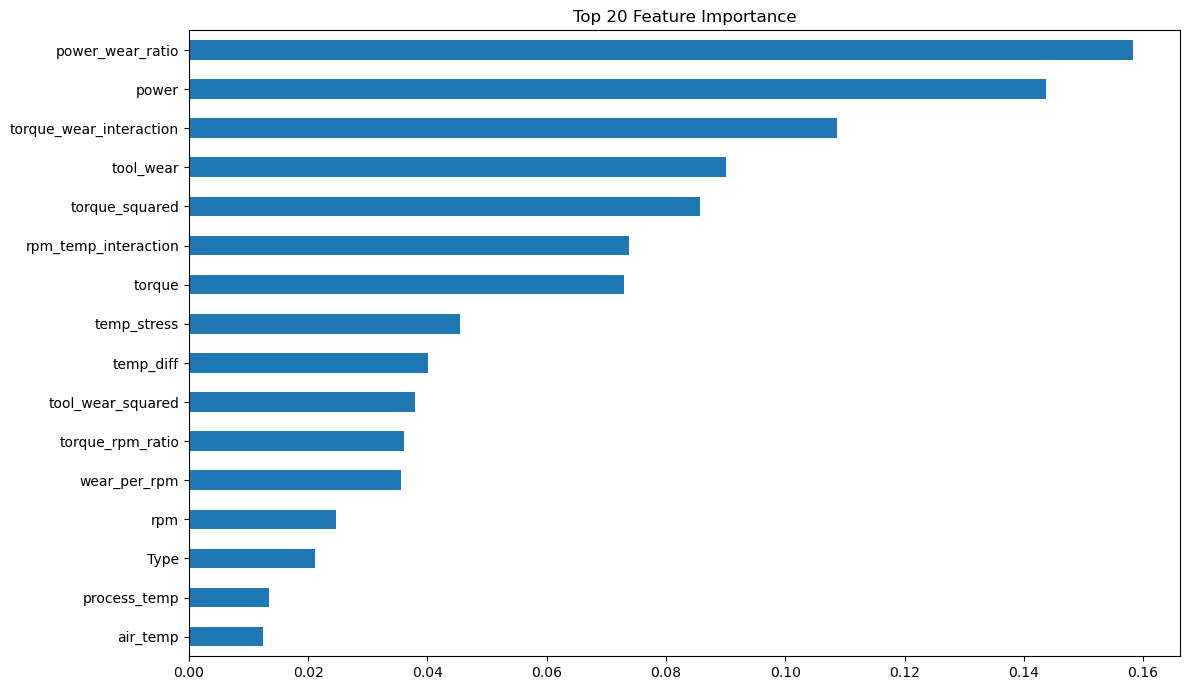

In [10]:
importance = pd.Series(best_model.feature_importances_, index=X.columns)
plt.figure(figsize=(12, 7))
importance.sort_values(ascending=True).tail(20).plot(kind="barh")
plt.title("Top 20 Feature Importance")
plt.tight_layout()
plt.show()

# EXPORT MODEL

In [11]:
joblib.dump(best_model, "model_prediction/model.pkl")
joblib.dump(scaler, "model_prediction/scaler.pkl")
joblib.dump(failure_le, "model_prediction/failure_le.pkl")
joblib.dump(type_le, "model_prediction/type_le.pkl")

['model_prediction/type_le.pkl']

# TESTING

In [15]:
def predict_failure(sensor_data):
    """
    Predict failure type from sensor readings

    Parameters:
    -----------
    sensor_data : dict
        Dictionary with keys:
        - Type: str ('L', 'M', or 'H')
        - air_temp: float (Kelvin)
        - process_temp: float (Kelvin)
        - rpm: int (rotational speed)
        - torque: float (Nm)
        - tool_wear: int (minutes)

    Returns:
    --------
    result : dict
        Prediction results with probabilities
    """
    # Load models
    model = joblib.load("model_prediction/model.pkl")
    scaler = joblib.load("model_prediction/scaler.pkl")
    failure_le = joblib.load("model_prediction/failure_le.pkl")
    type_le = joblib.load("model_prediction/type_le.pkl")

    # Create DataFrame
    df_input = pd.DataFrame([sensor_data])

    # Encode Type
    df_input["Type"] = type_le.transform(df_input["Type"])

    # Feature engineering (MUST match training!)
    df_input["temp_diff"] = df_input["process_temp"] - df_input["air_temp"]
    df_input["torque_rpm_ratio"] = df_input["torque"] / (df_input["rpm"] + 1e-5)
    df_input["power"] = df_input["torque"] * df_input["rpm"] / 9.5488
    df_input["temp_stress"] = df_input["process_temp"] / (
        df_input["air_temp"] + 1e-5
    )
    df_input["wear_per_rpm"] = df_input["tool_wear"] / (df_input["rpm"] + 1e-5)
    df_input["torque_squared"] = df_input["torque"] ** 2
    df_input["tool_wear_squared"] = df_input["tool_wear"] ** 2
    df_input["torque_wear_interaction"] = (
        df_input["torque"] * df_input["tool_wear"]
    )
    df_input["rpm_temp_interaction"] = df_input["rpm"] * df_input["temp_diff"]
    df_input["power_wear_ratio"] = df_input["power"] / (
        df_input["tool_wear"] + 1e-5
    )

    # Scale features
    X_scaled = scaler.transform(df_input)

    # Predict
    prediction = model.predict(X_scaled)[0]
    probabilities = model.predict_proba(X_scaled)[0]

    # Prepare result
    result = {
        "predicted_failure": failure_le.inverse_transform([prediction])[0],
        "confidence": float(probabilities[prediction]),
        "probabilities": {
            failure_le.inverse_transform([i])[0]: float(prob)
            for i, prob in enumerate(probabilities)
        },
        "input_data": sensor_data,
    }

    return result

In [16]:
test_case = {
    "Type": "M",
    "air_temp": 320,
    "process_temp": 300.4,
    "rpm": 1465,
    "torque": 59.1,
    "tool_wear": 91,
}

print("Test Case Power Failure")
print(f"Input: {test_case}")
result = predict_failure(test_case)
print(f"Predicted: {result['predicted_failure']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"All probabilities:")
for failure_type, prob in result["probabilities"].items():
    print(f"  {failure_type}: {prob:.2%}")

Test Case Power Failure
Input: {'Type': 'M', 'air_temp': 320, 'process_temp': 300.4, 'rpm': 1465, 'torque': 59.1, 'tool_wear': 91}
Predicted: Power Failure
Confidence: 99.81%
All probabilities:
  Heat Dissipation Failure: 0.07%
  No Failure: 0.10%
  Overstrain Failure: 0.00%
  Power Failure: 99.81%
  Random Failures: 0.00%
  Tool Wear Failure: 0.00%


In [17]:
test_case = {
    "Type": "M",
    "air_temp": 290.0,
    "process_temp": 308.3,
    "rpm": 1399,
    "torque": 46.4,
    "tool_wear": 132,
}

print("Test Case Random Failures")
print(f"Input: {test_case}")
result = predict_failure(test_case)
print(f"Predicted: {result['predicted_failure']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"All probabilities:")
for failure_type, prob in result["probabilities"].items():
    print(f"  {failure_type}: {prob:.2%}")

Test Case Random Failures
Input: {'Type': 'M', 'air_temp': 290.0, 'process_temp': 308.3, 'rpm': 1399, 'torque': 46.4, 'tool_wear': 132}
Predicted: Random Failures
Confidence: 90.96%
All probabilities:
  Heat Dissipation Failure: 0.12%
  No Failure: 8.29%
  Overstrain Failure: 0.10%
  Power Failure: 0.18%
  Random Failures: 90.96%
  Tool Wear Failure: 0.36%
